In [232]:
%matplotlib inline

# This module extracts inforation about mutations for a specific cohort

# Import libraries
import requests
import json
import collections
import matplotlib.pyplot as plt
from collections import Counter

def FetchData(Endpoint, Filters, Fields, Size):
    API_URL = 'https://gdc-api.nci.nih.gov/'
    Request = API_URL + Endpoint + '?' + 'filters=' + Filters + '&' + 'fields=' + Fields + '&' + 'size=' + Size
    r = requests.get(Request)
    data = json.loads(r.text)
    return data['data']['hits']

def ExtractTransversions(DNA_Changes):
    transversions=[]
    for dna_change in DNA_Changes:
        loc = dna_change['genomic_dna_change'].find('>') - 1
        if loc > 0:
            transversions.append(dna_change['genomic_dna_change'][loc:])
    return transversions

def ExtractInsertions(DNA_Changes):
    insertions=[]
    for dna_change in DNA_Changes:
        loc = dna_change['genomic_dna_change'].find('ins')
        if loc > 0:
            insertions.append('ins')
    return insertions

def ExtractDeletions(DNA_Changes):
    deletions=[]
    for dna_change in DNA_Changes:
        loc = dna_change['genomic_dna_change'].find('del')
        if loc > 0:
            deletions.append('del')
    return deletions

def ExtractChrPos(DNA_Changes):
    chrpos=[]
    for dna_change in DNA_Changes:
        loc = dna_change['genomic_dna_change'].find(':')
        if loc > 0:
            chrpos.append(dna_change['genomic_dna_change'][0:loc])
    return chrpos

def PlotData(Data):
    Counted_Data = Counter(Data)
    Sorted_Data = collections.OrderedDict(sorted(Counted_Data.items()))
    l = range(len(Sorted_Data))
    plt.bar(l, Sorted_Data.values(), align='center')
    plt.xticks(l, Sorted_Data.keys())
    plt.xticks(rotation=40)

def CalcPercentages(PSites, AllData):
    Percentages = []
    Total_Percentages = []
    for i in range(len(PSites)):
        for j in range(len(AllData[0])):
            try:
                gotdata = Data[i][j]
            except IndexError:
                gotdata = 0
            Percent = gotdata / sum(Data[i]) * 100
            Percentages.append(Percent)
        Total_Percentages.append(Percentages)
        Percentages = []
    return Total_Percentages

In [225]:
# Perform API Requests for various primary sites

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Primary_Sites = ['Breast', 'Lung', 'Skin', 'Brain', 'Kidney', 'Uterus','Bladder','Colorectal', \
                 'Liver', 'Prostate', 'Ovary','Cervix','Esophagus','Pancreas']

# Perform API Queries to generate matrix of data
PS_Data = []
for PS in Primary_Sites:
    EP = 'ssms'
    Filt = '%7B%22op%22%3A%22and%22%2C%22content%22%3A%5B%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22cases.primary_site%22%2C%22value%22%3A%5B%22' + PS + '%22%5D%7D%7D%5D%7D'
    F = 'genomic_dna_change'
    S = '200000'
    Data = FetchData(EP,Filt,F,S)
    PS_Data.append(Data)


In [237]:
Data = []
Cls = []

# Loop through the data to count the transversions / transitions
for i in range(len(PS_Data)):
    # Grab Transversion / Transitions / Insertions / Deletions
    T = ExtractTransversions(PS_Data[i])
    I = ExtractInsertions(PS_Data[i])
    D = ExtractDeletions(PS_Data[i])
    
    # Count
    Counted_Data = Counter(T)
    Counted_Insertions = (Counter(I))
    Counted_Deletions = (Counter(D))
    
    #Sort
    Sorted_Data = collections.OrderedDict(sorted(Counted_Data.items()))
    Data.append(list(Sorted_Data.values()))
    Cls.append(list(Sorted_Data.keys()))
    
    #Append Insertions and Deletions to the table
    Data[i].append(list(Counted_Insertions.values())[0])
    Cls[i].append('ins')
    
    Data[i].append(list(Counted_Deletions.values())[0])
    Cls[i].append('del')

# Calculate Percentages    
Pcts = CalcPercentages(Primary_Sites, Data)

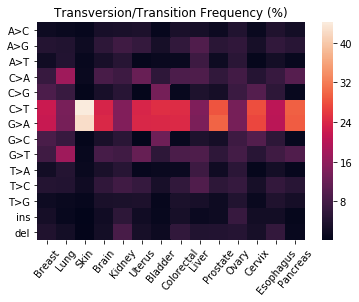

In [238]:
# Create a heat map of the data
data = pd.DataFrame(Pcts, columns= Cls[0], index = Primary_Sites)

ax = sns.heatmap(data.T)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(50)

ax.set_title('Transversion/Transition Frequency (%)')

In [240]:
# Create heat map of mutation frequency for chromosomal position
Data = []
Cls = []

for i in range(len(PS_Data)):
    # Grab Chromosomal Position
    chrpos = ExtractChrPos(PS_Data[i])
    
    # Count
    Counted_chrpos = (Counter(chrpos))
    
    #Sort
    Sorted_Data = collections.OrderedDict(sorted(Counted_chrpos.items()))
    Data.append(list(Sorted_Data.values()))
    Cls.append(list(Sorted_Data.keys()))

    
# Calculate Percentages
# Calculate Percentages 
Pcts = []
Pcts = CalcPercentages(Primary_Sites, Data)

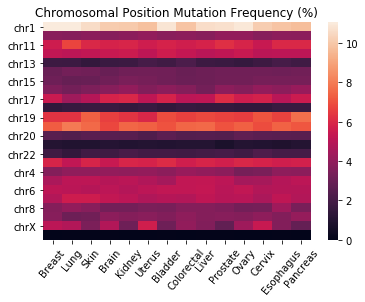

In [241]:
# Create a heat map of the data
data = pd.DataFrame(Pcts, columns= Cls[0], index = Primary_Sites)

ax = sns.heatmap(data.T)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(50)

ax.set_title('Chromosomal Position Mutation Frequency (%)')